In [8]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

from utils import show_images, blackAndWhite

import torch
import torch.nn as nn
import torch.optim as optim

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [10]:
import pandas as pd
import os
import shutil

df = pd.read_csv('inverted/invertedLabels.csv')
root = 'inverted'

for index, row in df.iterrows():
    imageName = f'{row["image"]}.jpeg'
    source = os.path.join(root, imageName)
    
    if os.path.exists(source):
        dest = os.path.join(f'{root}',f'{row["inverted"]}')
        dest = os.path.join(dest, imageName)
        shutil.move(source, dest)
    

In [11]:
batch_size = 4
scale_size = (1024, 1024)

root = 'inverted'

In [12]:
def crop(img):
    width, height = img.size
    return torchvision.transforms.functional.crop(img, 0, width/2, width, height)

images = ImageFolder(
    root=root,
    transform=transforms.Compose([
        transforms.Resize(scale_size),
        # transforms.Lambda(crop),
        transforms.ToTensor(), 
        transforms.Normalize([0.41661593, 0.29097975, 0.20843531], [0.26398131, 0.19219237, 0.15810781]),
        # transforms.Lambda(blackAndWhite),
    ])
)

train_size = int(0.8 * len(images))
test_size = len(images) - train_size

train_dataset, test_dataset = random_split(images, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5782024..3.5462868].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5782024..3.2810297].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5782024..2.5464716].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5782024..3.5258825].


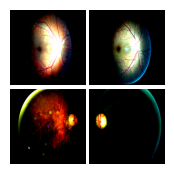

In [13]:
imgs, _ = next(iter(train_loader))
show_images(imgs.numpy().squeeze(), color=True)

In [ ]:
from InversionClassifier import InversionClassifier

model = InversionClassifier().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, fused=True, nesterov=True, momentum=0.9, weight_decay=1e-4)

num_epochs = 20

for epoch in range(num_epochs):
    print(f'Epoch: {epoch}')
    model.train()
    totLoss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        loss.backward()
        optimizer.step()
        
        totLoss += loss.item()
    
    print(f'Avg Loss: {totLoss / len(train_loader)}')
    
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:   
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, pred = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (pred == labels).sum().item()
            
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy}%')


Epoch: 0
Avg Loss: 0.40085704729222416
Accuracy: 93.42105263157895%
Epoch: 1
Avg Loss: 0.31196331747464445
Accuracy: 88.59649122807018%
Epoch: 2
Avg Loss: 0.2845746398364243
Accuracy: 94.29824561403508%
Epoch: 3
Avg Loss: 0.26719775230198967
Accuracy: 93.85964912280701%
Epoch: 4
Avg Loss: 0.250420255439454
Accuracy: 94.29824561403508%
Epoch: 5
Avg Loss: 0.2630056667942227
Accuracy: 92.98245614035088%
Epoch: 6
Avg Loss: 0.24107800295020929
Accuracy: 94.29824561403508%
Epoch: 7
Avg Loss: 0.24444865507661903
Accuracy: 94.29824561403508%
Epoch: 8
Avg Loss: 0.24367148393005328
Accuracy: 94.73684210526316%
Epoch: 9
Avg Loss: 0.2249393935944362
Accuracy: 93.85964912280701%
Epoch: 10
Avg Loss: 0.232829666386048
Accuracy: 93.85964912280701%
Epoch: 11
Avg Loss: 0.2265549557683826
Accuracy: 93.42105263157895%
Epoch: 12
Avg Loss: 0.22721717602842928
Accuracy: 92.98245614035088%
Epoch: 13
